In [101]:
import math
import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import kornia as K
from scipy import ndimage
import numpy as np

In [102]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Image Size: torch.Size([28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100, 237,
         121,   0,   0,   0,   0,   0,   0,  13,  48,  18,   0,   0,   0,   0],
        [  0,

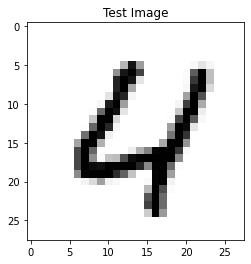

In [103]:
DATASET_PATH = "./data"

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                AddGaussianNoise(0., .75)])

train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

TEST_IMG_INDEX = 64

img = train_set.data[TEST_IMG_INDEX]
print(f"Image Size: {img.size()}")
print(img)
plt.title("Test Image")
plt.imshow(img, cmap="Greys")

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [104]:
input_imgs = torch.clone(train_set.data)
input_imgs.data.to(torch.float)
print(input_imgs.data.size())
noise = torch.rand(input_imgs.data.size(), device=train_set.data.device) * 255


noisy_imgs = input_imgs.data.add(noise.data.int())
noisy_imgs.data.clamp_(min=0, max=511)

clean_img = input_imgs.data[TEST_IMG_INDEX]
noisy_img = noisy_imgs.data[TEST_IMG_INDEX]

noisy_img_removed = torch.clone(noisy_img)

rand_chance = np.random.randint(0, 28, size=28)
rand_lines = np.random.randint(0, 28, size=28)

for i in rand_lines:
    if rand_chance[i] < 4:
        for j in range(noisy_img_removed.size()[0]):
            noisy_img_removed[j][rand_lines[i]] = 0

torch.Size([60000, 28, 28])


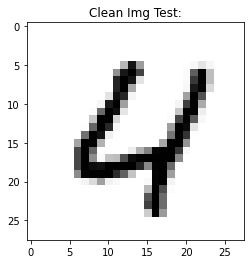

In [105]:
plt.title("Clean Img Test:")
plt.imshow(clean_img, cmap="Greys")

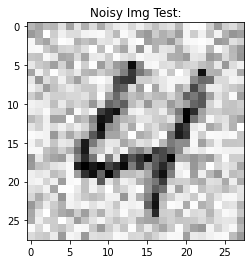

In [106]:
plt.title("Noisy Img Test:")
plt.imshow(noisy_img, cmap="Greys")

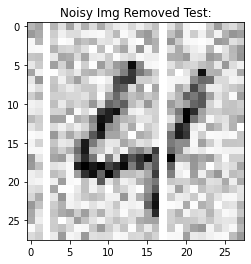

In [107]:
plt.title("Noisy Img Removed Test:")
plt.imshow(noisy_img_removed, cmap="Greys")

In [108]:
ALPHA = 0.01
BETA = 0.05

Gradient Calculation Test:


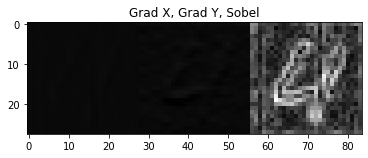

In [109]:
print("Gradient Calculation Test:")

sy = ndimage.sobel(noisy_img_removed,axis=0,mode='constant')
sx = ndimage.sobel(noisy_img_removed,axis=1,mode='constant')

sobel=np.hypot(sx,sy)
plots = np.concatenate((sx*ALPHA, sy*BETA, sobel), axis = 1)
plt.title("Grad X, Grad Y, Sobel")
plt.imshow(plots,cmap=plt.cm.gray)
plt.show()

In [110]:
def grads(img):
    sy = ndimage.sobel(img,axis=0,mode='nearest')
    sx = ndimage.sobel(img,axis=1,mode='nearest')

    #sobel=np.hypot(sx,sy)

    return sx, sy

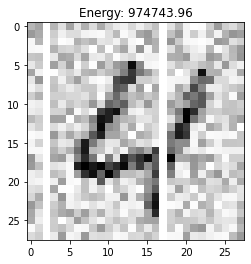

In [111]:
u = noisy_img_removed
sx, sy = grads(noisy_img_removed)
e1 = ALPHA * sx + BETA * sy
e2 = torch.subtract(noisy_img, noisy_img_removed)
e2 = e2.numpy()
e2 = np.square(e2)
e2 = np.multiply(e2, 0.5)
energy = np.add(e1, e2)
plt.title(f"Energy: {np.sum(energy)}")
plt.imshow(u, cmap="Greys")

In [112]:
def energy(f, u):
    sx, sy = grads(u)
    e1 = ALPHA * sx + BETA * sy
    e2 = torch.subtract(f, u)
    e2 = e2.numpy()
    e2 = np.square(e2)
    e2 = np.multiply(e2, 0.5)
    energy = np.add(e1, e2)
    return np.sum(energy)


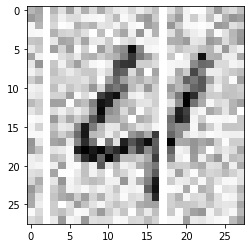

In [113]:
learning_rate = 1e-3
iterations = []
u = torch.zeros(noisy_img.shape)
plt.imshow(noisy_img_removed, cmap="Greys")

for i in range(0, 512000):
    dx, dy = grads(u)
    dxx, dyx = grads(dx/np.sqrt(np.square(dx + 0.0001)))
    dxy, dyy = grads(dy/np.sqrt(np.square(dy + 0.0001)))

    du = np.add((ALPHA * dxx + BETA * dyy), np.subtract(noisy_img, u))
    u = u + learning_rate * du

    if (i % 64 == 0):
        iterations.append(u)


In [114]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

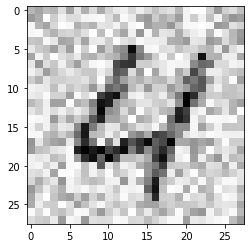

In [115]:
plt.imshow(iterations[0], cmap="Greys")

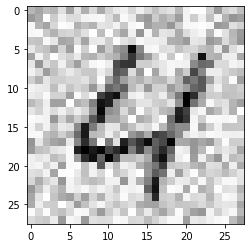

In [116]:
plt.imshow(iterations[630],cmap="Greys")

2000.0
Iteration 0 Energy:14308837.6231685
Iteration 4 Energy:8625198.861702591
Iteration 8 Energy:5296324.662678229
Iteration 12 Energy:3361018.64875597
Iteration 16 Energy:2247289.8946536747
Iteration 20 Energy:1615455.1355105024
Iteration 24 Energy:1264333.8848207253
Iteration 28 Energy:1075200.2253265828
Iteration 32 Energy:978321.3235973692
Iteration 36 Energy:933001.6191735333
Iteration 40 Energy:915698.0033923654
Iteration 44 Energy:912954.4963515374
Iteration 48 Energy:917211.8991189259
Iteration 52 Energy:924330.4366192549
Iteration 56 Energy:932131.0867071997
Iteration 60 Energy:939541.5160085744
Iteration 64 Energy:946099.7656684641
Iteration 68 Energy:951668.7812646104
Iteration 72 Energy:956274.6040426462
Iteration 76 Energy:960016.5590627356
Iteration 80 Energy:963018.9443280576
Iteration 84 Energy:965406.3841986688
Iteration 88 Energy:967292.4280934397
Iteration 92 Energy:968775.0952109178
Iteration 96 Energy:969936.3875258135
Iteration 100 Energy:970843.4616002734
Itera

IndexError: index 5 is out of bounds for axis 0 with size 5

<Figure size 432x288 with 0 Axes>

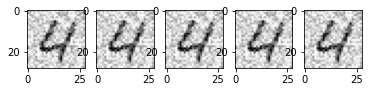

In [117]:
plt.figure()

f, axarr = plt.subplots(1, 5)
plt.set_cmap("Greys")

print(iterations.__len__() / 4)
for i in range (0, iterations.__len__()):
    if i % 4 ==0:
        print(f"Iteration {i} Energy:{energy(noisy_img_removed, iterations[i])}")


for i in range(0, 512):
    #print(f"Iteration {(i * 4 - 1, 0)[i ==0]} Energy: {energy(noisy_img, iterations[(i * 4 - 1, 0)[i ==0]])}")
    axarr[i].imshow(iterations[(i * 4 - 1, 0)[i ==0]])